## AdaBoost Algorithm

INPUT:

1. $m$ examples $\mathbb{S} = \{(x_1,y_1),\cdots,(x_m,y_m)\}$

2. Base learner $h(x)$

INITIALIZE:

Weights $w_i = \frac{1}{m}$

FOR $t$ in $1:T$:

   1.Train weighted examples set $(w_t,x)$ to obtain $h_t$
   
   2.Compute error $\epsilon_t$
   
   3.Compute classifier weights $\alpha_t$
   
   4.Update $w_{t+1}$
    
OUTPUT:

$H(x) = sign(\sum_t^T\alpha_th_t(x))$

## Derive

Assume final classifier $H(x)=sign(\sum_t^T\alpha_th_t(x))$

\begin{align*}
err_\mathbb{S}(H) &\equiv \mathbb{P}_{\mathbb{S}}(y\not = H(x))\\
                  &= \frac{1}{m}\sum_{i=1}^m\mathbb{I}\{y_i\not = H(x_i)\}\\
                  &\leq \frac{1}{m}\sum_{i=1}^me^{-y_iH(x_i)}\\
                  &=\sum_{i=1}^m\frac{1}{m}e^{-y_i\sum_{t=1}^T\alpha_th_t(x_i)}\\
                  &=Z_1\sum_{i=1}^m\frac{1}{m}e^{-y_i\alpha_1h_1(x_i)}e^{-y_i\sum_{t=2}^T\alpha_th_t(x_i)}\\
\end{align*}

Let $w_i^1=\frac{1}{m}$, $w_i^2=\frac{\frac{1}{m}e^{-y_i\alpha_1h_1(x_i)}}{\sum_{i=1}^m\frac{1}{m}e^{-y_i\alpha_1h_1(x_i)}}$

$Z_1=\sum_{i=1}^m\frac{1}{m}e^{-y_i\alpha_1h_1(x_i)}$

\begin{align*}
err_\mathbb{S}(H) &\leq \sum_{i=1}^mw_i^2e^{-y_i\alpha_2h_2(x_i)}e^{-y_i\sum_{t=3}^T\alpha_th_t(x_i)}\\
                  &= Z_1Z_2\sum_{i=1}^m\frac{w_i^2e^{-y_i\alpha_2h_2(x_i)}}{Z_2}e^{-y_i\sum_{t=3}^T\alpha_th_t(x_i)}\\
\end{align*}

Where $Z_2=\sum_{i=1}^mw_i^2e^{-y_i\alpha_2h_2(x_i)}$, and 

Let $w_i^3=\frac{w_i^2e^{-y_i\alpha_2h_2(x_i)}}{Z_2}$

$$\cdots \cdots$$

\begin{align*}
err_\mathbb{S}(H)&\leq \prod_{t=1}^T Z_t \sum_{i=1}^m w_i^{T+1}\\
                  &= \prod_{t=1}^TZ_t\\
                  &=\prod_{t=1}^T\sum_{i=1}^mw_i^te^{-y_i\alpha_th_t(x_i)}\\
                  &=\prod_{t=1}^T(\sum_{i\in C}w_i^te^{-\alpha_t}+\sum_{i\in M}w_i^te^{\alpha_t})\\
                  &=\prod_{t=1}^T((1-\epsilon_t)e^{-\alpha_t}+\epsilon_te^{\alpha_t})
\end{align*}

Notice that $\epsilon_t=\mathbb{P}_{w^t}(y\not=h_t(x))=\sum_{i\in M}w_i^t$

We need to minimize the upper bound.

$$g(\alpha_t)=(1-\epsilon_t)e^{-\alpha_t}+\epsilon_te^{\alpha_t}$$

$$g^\prime(\alpha_t)=-(1-\epsilon_t)e^{-\alpha_t}+\epsilon_te^{\alpha_t}$$

Set $g^\prime(\alpha_t)=0$:

$$\alpha_t = \frac{1}{2}\log\frac{1-\epsilon_t}{\epsilon_t}$$

\begin{align*}
err_\mathbb{S}(H)&\leq \prod_{t=1}^T2\sqrt{\epsilon_t(1-\epsilon_t)}\\
                 &=\prod_{t=1}^T2\sqrt{1-4\gamma_t^2}\\
                 &\leq \prod_{t=1}^T e^{-2\gamma_t}\\
                 &=e^{-2\sum_{t=1}^T\gamma_t}
\end{align*}

Where $\epsilon_t=\frac{1}{2}-\gamma_t$, and we have the identity:

$$1-x\leq e^{-x}$$

Let $\gamma = \min_t \gamma_t$,


$$err_\mathbb{S}(H)\leq e^{-2T\gamma^2}$$

For now, we bound $err_\mathbb{S}(H)$, and the minimum number of iterations for $\epsilon$-error is:

$$T=\frac{1}{2\gamma^2}\log{\frac{1}{\epsilon}}$$

i.e. $T = \mathcal{O}(\frac{1}{\gamma^2}\log{\frac{1}{\epsilon}})$ with big O notation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class base:
    def __init__(self,X,y):
        self.X = X
        self.y = y
    # Given a feature, a rule "mode" = ">" or "<", if X['feature'] "mode" threshold return -1 class
    def decision_stump(self,mode,feature,threshold):
        ret = np.ones(np.array(self.y).shape).flatten()
        if mode == "<":
            ret[self.X[:,feature] <= threshold] = -1.0
        else:
            ret[self.X[:,feature] >= threshold] = -1.0
        return ret
    def find_optimal_classifier(self,w,steps = 10):
        min_error = np.inf
        #obs: num of samples, feature: num of features
        obs,feature = self.X.shape
        optimal_classifier = {}
        optimal_predict = np.zeros(obs)
        #loop over all features to find the optimal feature & threshold
        for d in range(feature):
            feat_min = self.X[:,d].min()
            feat_max = self.X[:,d].max()
            step_size = (feat_max - feat_min)/float(steps)
            for step in range(int(steps) + 1):
                for mode in ["<",">"]:
                    threshold = feat_min + float(step) * step_size
                    predict_value = self.decision_stump(mode,d,threshold)
                    rate = np.ones(obs)
                    rate[predict_value == self.y] = 0
                    weight_rate = np.dot(w.T, rate)
                    if weight_rate < min_error:
                        min_error = weight_rate
                        optimal_classifier["feature"] = d
                        optimal_classifier["threshold"] = threshold
                        optimal_classifier["mode"] = mode
                        optimal_predict = predict_value.copy()
        return optimal_classifier,optimal_predict,min_error

In [3]:
class AdaBoost:
    def __init__(self,X,y,base):
        self.X = np.array(X)
        self.y = np.array(y)
        self.base = base       
    def train(self,T):
        #alpha[i]: the weight of the i-th classifier
        #boost: collection of weak classifier
        #w: the weight of each point
        #sign(f): the combination of previous classifiers for now
        #f_error: the error rate of current classifier
        self.alpha = []
        self.h = {}    
        self.boost = []
        self.w = np.ones(self.y.shape[0])*1.0/len(y)       
        self.f = np.zeros(self.y.shape)        
        self.f_error = np.inf
        error_list = []
        for t in range(T):
            self.h[t] = self.base(self.X,self.y)
            classifier,predict,error = self.h[t].find_optimal_classifier(self.w)
            self.boost.append(classifier)
            self.alpha.append(0.5 * np.log((1.0-error)/error))# Add Laplacian smooth
            self.f = self.f + self.alpha[t] * predict
            self.f_error = np.dot((np.sign(self.f) != self.y),np.ones(self.y.shape[0]))/float(self.y.shape[0])
            error_list.append(self.f_error)
            if self.f_error == 0:
                break
            w_next = self.w * np.exp(-self.alpha[t]*self.y*predict)
            self.w = (w_next/w_next.sum())
        return self.boost,error_list
    #flag: single input for 0, multi-input for 1
    def classifier(self,x,flag = 1):
        if flag == 0:
            x = x[np.newaxis]
        base_result = np.zeros(x.shape[0])
        for i in range(len(self.boost)):
            label = np.ones(x.shape[0])
            if self.boost[i]['mode'] == '>':
                label[np.where(x[:,self.boost[i]['feature']] >= self.boost[i]['threshold'])] = -1
            else:
                label[np.where(x[:,self.boost[i]['feature']] <= self.boost[i]['threshold'])] = -1
            base_result += base_result + self.alpha[i] * label
        return np.sign(base_result)

In [4]:
X = np.array([[1,2],[2,3],[3,4],[3,2],[3,1],[4,4],[5,4],[5,2],[5,1]])
y = np.array([1,1,-1,-1,-1,-1,-1,1,1]) 

In [5]:
adaboost = AdaBoost(X,y,base)

In [6]:
adaboost.train(5)

([{'feature': 0, 'mode': '>', 'threshold': 2.2000000000000002},
  {'feature': 1, 'mode': '>', 'threshold': 3.1000000000000001},
  {'feature': 0, 'mode': '<', 'threshold': 4.2000000000000002}],
 0.0)

In [7]:
adaboost.alpha

[0.62638148424768403, 0.89587973461402748, 0.97295507452765662]

(0.5, 5.5)

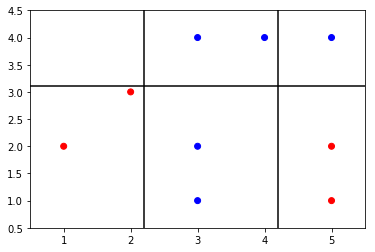

In [8]:
d = {1:'r',-1:'b'}
l = []
for i in y:
    l.append(d[i])
plt.scatter(X[:,0],X[:,1],color=l)
plt.vlines(2.2,0.5,4.5)
plt.hlines(3.1,0.5,5.5)
plt.vlines(4.2,0.5,4.5)
plt.ylim(0.5,4.5)
plt.xlim(0.5,5.5)

In [9]:
adaboost.classifier(np.array([1,1]),flag=0)

array([ 1.])